# Residual Networks

## Packages

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

%matplotlib inline

## The Problem of Very Deep Neural Networks

In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

* More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values). 

* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds, as shown below: 

## Building a Residual Network

### Identity Block
These are the individual steps:

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no hyperparameters. 

In [3]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    cache = []
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X]) 
    X = Activation('relu')(X)
    
    return X

### The Convolutional Block
The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 

In [5]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training) 
    X = Activation('relu')(X) 

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)  
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut) 
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training) 

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Building a ResNet with 50 layers
You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [7]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2) 
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512]) 
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024])  
    X = identity_block(X, 3, [256, 256, 1024])  
    X = identity_block(X, 3, [256, 256, 1024])  
    X = identity_block(X, 3, [256, 256, 1024])  

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)  
    X = identity_block(X, 3, [512, 512, 2048])   
    X = identity_block(X, 3, [512, 512, 2048])    

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2))(X) 
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

Run the following code to build the model's graph. If your implementation is incorrect, you'll know it by checking your accuracy when running model.fit(...) below.

In [8]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

Prior to training a model, you need to configure the learning process by compiling the model.

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. The only thing you need now is a dataset!

Let's load your old friend, the SIGNS dataset.

In [10]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


Run the following cell to train your model on 10 epochs with a batch size of 32. On a GPU, it should take less than 2 minutes.

In [11]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 82s 2s/step - loss: 1.7767 - accuracy: 0.4824
Epoch 2/10
34/34 [==============================] - 69s 2s/step - loss: 0.5389 - accuracy: 0.8093
Epoch 3/10
34/34 [==============================] - 67s 2s/step - loss: 0.3514 - accuracy: 0.8880
Epoch 4/10
34/34 [==============================] - 66s 2s/step - loss: 0.1928 - accuracy: 0.9370
Epoch 5/10
34/34 [==============================] - 66s 2s/step - loss: 0.5044 - accuracy: 0.8657
Epoch 6/10
34/34 [==============================] - 71s 2s/step - loss: 0.5040 - accuracy: 0.8296
Epoch 7/10
34/34 [==============================] - 66s 2s/step - loss: 0.1227 - accuracy: 0.9620
Epoch 8/10
34/34 [==============================] - 66s 2s/step - loss: 0.2224 - accuracy: 0.9352
Epoch 9/10
34/34 [==============================] - 66s 2s/step - loss: 0.0864 - accuracy: 0.9694
Epoch 10/10
34/34 [==============================] - 66s 2s/step - loss: 0.6015 - accuracy: 0.8824


Let's see how this model (trained on only two epochs) performs on the test set.

In [12]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 3s 292ms/step - loss: 0.7813 - accuracy: 0.7250
Loss = 0.781268835067749
Test Accuracy = 0.7250000238418579


# Test on Your Own Image

Input image shape: (1, 64, 64, 3)
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[9.9616361e-01 6.3147712e-07 3.8201457e-03 8.1606095e-06 5.0201502e-06
  2.4333460e-06]]
Class: 0


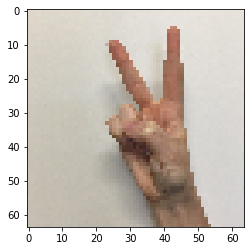

In [14]:
img_path = 'images/sign.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))
